In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [2]:
train = pd.read_csv('forty_column_dataset.csv')

In [46]:
import scipy
from scipy import stats

In [47]:
scipy.stats.itemfreq(train['labels'])

array([[  0.00000000e+00,   2.88857000e+06],
       [  1.00000000e+00,   2.27000000e+04]])

In [48]:
master_mask = np.arange(len(train['labels']))

In [49]:
master_mask[np.array(train['labels'])==0]

array([      0,       1,       2, ..., 2911267, 2911268, 2911269])

In [50]:
pos_choices = np.random.choice(master_mask[np.array(train['labels'])==1], size=2*2.27000000e+04/3)
neg_choices = np.random.choice(master_mask[np.array(train['labels'])==0], size=2*2.88857000e+06/3)

/home/of3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/of3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [51]:
List = np.concatenate((neg_choices, pos_choices))

In [54]:
train_2 = train.ix[List]

In [ ]:
train_3 = train_2.drop([u'Unnamed: 0', u'CustomerMD5Key', u'FirstDriverDrivingLicenseNumberY', u'VoluntaryExcess', \
                                   u'CarParkingTypeId',u'FirstDriverDrivingLicenceType',\
                                   u'CarDrivingEntitlement',  u'CarTransmissionId', u'PolicyHolderResidencyArea'\
                        , u'car_flag_4', u'car_flag_5', u'car_flag_6'], axis=1)

In [11]:
train_3.to_csv("inter_train301")

In [5]:
train_3 = pd.read_csv("inter_train301")

In [10]:
target = 'labels'
#IDcol = 'index'

In [17]:
np.count_nonzero(train_3['labels']==1)

7566

In [3]:
juiceboy = pd.read_csv('juice_test_final.csv')

In [4]:
juiceboy = juiceboy.drop([u'Unnamed: 0', u'CustomerMD5Key', u'FirstDriverDrivingLicenseNumberY', u'VoluntaryExcess', \
                                   u'CarParkingTypeId',u'FirstDriverDrivingLicenceType',\
                                   u'CarDrivingEntitlement',  u'CarTransmissionId', u'PolicyHolderResidencyArea'\
                        , u'car_flag_4', u'car_flag_5', u'car_flag_6'], axis=1)

In [24]:
def modelfit(alg, dtrain, predictors, supplied_arr, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['labels'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtrain_predlabels = alg.predict_proba(supplied_arr)
    
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['labels'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['labels'], dtrain_predprob)
    
    return dtrain_predlabels
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [34]:
xgbl = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

supplied_arr = juiceboy
predictors = [x for x in train_3.columns if x not in [target,'Unnamed: 0', u'CustomerMD5Key']]
dtrain = train_3
alg = xgbl
useTrainCV=True
cv_folds=5
early_stopping_rounds=50
predictors = [x for x in train_3.columns if x not in [target,'Unnamed: 0', u'CustomerMD5Key']]
    
if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
alg.fit(dtrain[predictors], dtrain['labels'],eval_metric='auc')

#Predict training set:
dtrain_predictions = alg.predict(dtrain[predictors])
dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

dtrain_predlabels = alg.predict_proba(supplied_arr)


print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['labels'].values, dtrain_predictions)
print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['labels'], dtrain_predprob)


Model Report
Accuracy : 0.9993
AUC Score (Train): 0.999891


In [6]:
import joblib

In [38]:
joblib.dump(alg, 'filename.pkl') 

['filename.pkl']

In [7]:
clf = joblib.load('filename.pkl')

In [8]:
supplied_arr = juiceboy

In [9]:
check_arr = clf.predict_proba(supplied_arr)

In [10]:
np.savetxt("shiok_alpha_final.csv", [x[1] for x in check_arr], delimiter="\n")

In [43]:
np.count_nonzero(check_arr != dtrain_predlabels)

0

In [35]:
print "done_shiok_sia"

done_shiok_sia


In [26]:
predictors = [x for x in train_3.columns if x not in [target,'Unnamed: 0', u'CustomerMD5Key']]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

ans_proba = modelfit(xgb1, train_3, predictors,juiceboy)


Model Report
Accuracy : 0.9993
AUC Score (Train): 0.999891


In [28]:
np.savetxt("hyper_shiokalpha.csv", ans_proba, delimiter="\n")

(303913, 2)

In [31]:
np.savetxt("hyper_shiokalpha_2.csv", [x[1] for x in ans_proba] , delimiter="\n")


Model Report
Accuracy : 0.9993
AUC Score (Train): 0.999891


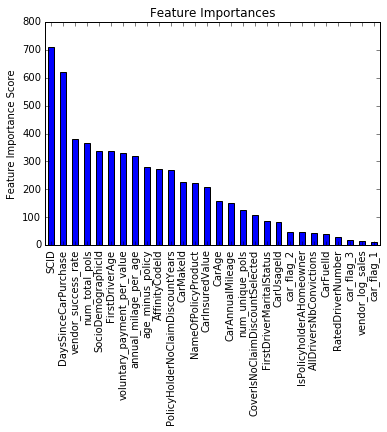

In [12]:
ans_prob